In [ ]:
!python --version

Test notebook to try out the Amazon SageMaker Studio. Lets get a submission to the Spaceship Titatic Kaggle competition.

Lets get the basic data loaded

In [ ]:
# Not really needed
# !pip install kaggle

Lets get the Kaggle token installed. Manually move the kaggle jason file to the root .kaggle folder.

Lets download the data

In [ ]:
# Only needed the first time
# !kaggle competitions download -c spaceship-titanic

Now to unzip it.

In [ ]:
# !unzip ./spaceship-titanic.zip

Cool. Lets get the basic data into a dataframe.

In [1]:
import pandas as pd
import numpy as np
tdata = pd.read_csv('train.csv')

In [4]:
tdata.shape

(8693, 14)

In [2]:
tdata.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Lets get some basic summary statistics going.

In [5]:
tdata.describe(include = 'all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


Lets check for missing values

In [6]:
tdata.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
tdata.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

### Feature Engineering

Lets get some basic feature engineering going.

First up, lets get the cabin sorted out into decks, cabin numbers and side of the ship.

In [8]:
tdata['Cabin'][:10]

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
5    F/0/P
6    F/2/S
7    G/0/S
8    F/3/S
9    B/1/P
Name: Cabin, dtype: object

In [9]:
#Re-writing this to make it a function
def split_cabin (df):
    df[['Cabin_Deck', 'Cabin_number', 'Cabin_side']] = df['Cabin'].str.split('/',expand=True)
    return df

Alright, lets get Passenger group sorted. I think we need to get this into two columns. Group_size and # of Family.

In [10]:
# Re-writing to make this a function
def passenger_group(df):
    df[['PassengerID_Group','PassengerID_Number']] = df['PassengerId'].str.split('_',expand=True)
    return df

In [11]:
# Re-writing to make it a function
def add_party_size (df):

    def get_party_size(grp):
        ans = []
        for grp_id in grp:
            ans.append(len(tdata.loc[tdata['PassengerID_Group'] == grp_id]))
        return ans

    df['PassengerID_GroupSize'] = get_party_size(df['PassengerID_Group'])
    return df

Ok lets call all the feature eng functions together.

In [12]:
def add_features(df):
    # Removing old function
    # boolify(df)
    split_cabin(df)
    passenger_group(df)
    add_party_size (df)
    return df.head()

add_features(tdata)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Deck,Cabin_number,Cabin_side,PassengerID_Group,PassengerID_Number,PassengerID_GroupSize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0001,01,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,0002,01,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,0003,01,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S,0003,02,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S,0004,01,1


In [ ]:
tdata.head()

Lets take a closer look at Cabin_number.

In [36]:
tdata['Cabin_number'].describe()

count     8494
unique    1817
top         82
freq        28
Name: Cabin_number, dtype: object

In [52]:
deep_dive = tdata[tdata['Cabin_number'] == '82']
deep_dive.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Deck,Cabin_number,Cabin_side,PassengerID_Group,PassengerID_Number,PassengerID_GroupSize
326,0368_01,Mars,False,F/82/P,TRAPPIST-1e,26.0,False,2832.0,107.0,4447.0,15.0,4.0,Resers Perte,False,F,82,P,0368,01,2
327,0368_02,Mars,True,F/82/P,TRAPPIST-1e,61.0,False,0.0,0.0,0.0,0.0,0.0,Batech Perte,True,F,82,P,0368,02,2
492,0531_01,Earth,True,G/82/P,55 Cancri e,1.0,False,0.0,0.0,0.0,0.0,0.0,Estine Alentonway,False,G,82,P,0531,01,2
493,0531_02,Earth,True,G/82/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Darley Alentonway,True,G,82,P,0531,02,2
525,0561_01,Earth,False,G/82/S,TRAPPIST-1e,22.0,False,0.0,0.0,332.0,442.0,0.0,Jessa Flemaney,False,G,82,S,0561,01,1


Ok lets get rid of Cabin number - seems to not be predictive.

Cool. Lets get a basic learning model going.

In [53]:
cat_vars = list(tdata.select_dtypes(['object','bool']).columns)
cat_vars.remove('Name')
cat_vars.remove('PassengerId')
cat_vars.remove('Transported')
cat_vars.remove('Cabin')
cat_vars.remove('PassengerID_Group')
cat_vars.remove('Cabin_number')
# Lets add this back in.
# cat_vars.remove('PassengerID_Number')
# print(cat_vars)
print(f"Category variables are: \n {cat_vars}")

cont_vars = list(tdata.select_dtypes(['int','float']).columns)
# print(cont_vars)
print(f"Continous variables are: \n {cont_vars}")

# not_used_vars = ['Name','PassengerId', 'Cabin', 'PassengerID_Group', 'PassengerID_Number']
not_used_vars = ['Name','PassengerId', 'Cabin', 'PassengerID_Group', 'Cabin_number']
# print(not_used_vars)
print(f"Unused variables are: \n {not_used_vars}")

total_columns = len(cont_vars)+len(cat_vars)+len(not_used_vars)
print(total_columns)
tdata.shape

Category variables are: 
 ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_side', 'PassengerID_Number']
Continous variables are: 
 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerID_GroupSize']
Unused variables are: 
 ['Name', 'PassengerId', 'Cabin', 'PassengerID_Group', 'Cabin_number']
19


(8693, 20)

In [24]:
tdata['Transported'].dtype
# dep_vars = list(tdata.select_dtypes('bool').columns)
dep_vars = ['Transported']
print(dep_vars)

['Transported']


In [25]:
from fastai.tabular.all import *

Lets get all the basic column names into variables. This will come in handy later.

Lets get a basic tabular pandas model going.

In [ ]:
# for n in tdata:
#     if pd.api.types.is_object_dtype(tdata[n]):
#         tdata[n] = tdata[n].astype('category')

Critical error here!! Make sure you dont pass in strings!! You are trying to pass in the actual objects!!

In [26]:
procs = [Categorify, FillMissing, Normalize]

In [54]:
splits = RandomSplitter(valid_pct=0.2)(tdata)

In [55]:
to = TabularPandas(tdata,splits = splits, do_setup=True, procs = procs,
                   cat_names = cat_vars, cont_names = cont_vars,
                   y_names = dep_vars, y_block = CategoryBlock())
to.show()

,HomePlanet,CryoSleep,Destination,VIP,Cabin_Deck,Cabin_side,PassengerID_Number,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerID_GroupSize,Transported
8363,Earth,False,TRAPPIST-1e,False,G,S,03,False,False,False,False,False,False,1.800000e+01,327.0,1.700000e+02,0.0,0.0,130.0,3.0,False
7665,Earth,False,TRAPPIST-1e,False,G,S,01,False,False,True,False,False,False,3.100000e+01,116.0,-5.684342e-14,298.0,2.0,227.0,1.0,False
7230,Earth,False,55 Cancri e,False,E,S,01,False,False,False,False,False,False,3.300000e+01,0.0,-5.684342e-14,0.0,436.0,224.0,1.0,True
63,Earth,False,55 Cancri e,False,F,S,03,False,False,False,False,False,False,2.100000e+01,1946.0,3.700000e+01,0.0,0.0,24.0,3.0,False
2032,Earth,False,PSO J318.5-22,False,G,S,01,False,False,False,False,False,False,2.300000e+01,0.0,7.740000e+02,0.0,0.0,0.0,1.0,True
8092,Earth,False,TRAPPIST-1e,False,F,S,02,False,False,False,False,False,False,2.900000e+01,0.0,-5.684342e-14,0.0,0.0,1972.0,2.0,False
7169,Earth,True,TRAPPIST-1e,False,G,S,01,False,False,False,False,False,False,3.552714e-15,0.0,-5.684342e-14,0.0,0.0,0.0,5.0,True
5017,Mars,True,TRAPPIST-1e,False,F,P,01,False,False,False,False,False,False,3.800000e+01,0.0,-5.684342e-14,0.0,0.0,0.0,1.0,True
5085,Earth,False,55 Cancri e,False,E,S,01,False,False,False,False,True,False,3.300000e+01,2.0,-5.684342e-14,0.0,0.0,720.0,1.0,True
6882,Europa,False,55 Cancri e,False,A,P,01,False,False,False,False,False,False,5.200000e+01,360.0,1.314000e+03,8.0,641.0,66.0,1.0,True


In [ ]:
to.ys

In [ ]:
to.xs.iloc[:2]

In [33]:
to.cats

,HomePlanet,CryoSleep,Destination,VIP,Cabin_Deck,Cabin_number,Cabin_side,PassengerID_Number,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na
6154,0,1,3,1,3,935,1,4,1,1,1,1,1,1
4614,2,1,1,2,2,927,2,1,1,1,1,1,1,1
6773,1,1,2,1,6,414,2,1,1,1,1,1,1,1
1855,0,2,3,1,7,1057,2,1,1,1,1,1,1,1
3115,2,1,3,2,1,1044,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,1,1,3,1,6,1506,2,1,1,1,1,1,1,2
2548,1,1,1,1,7,1194,2,2,1,1,1,1,1,1
6461,1,1,3,1,6,461,1,1,1,1,1,1,1,1
4537,1,1,3,1,7,1572,1,1,1,1,1,2,1,1


In [ ]:
to.conts

In [ ]:
to.xs

Lets create a dataloader

In [ ]:
to.cats.dtypes

SO! The following cell was just to resolve the error I got using FastAI. Critical error was not passing in proc objects - I kept sending in strings!

In [ ]:
tensor(to.cats)

In [56]:
dls = to.dataloaders(path = '.')
dls.show_batch()

,HomePlanet,CryoSleep,Destination,VIP,Cabin_Deck,Cabin_side,PassengerID_Number,Age_na,RoomService_na,FoodCourt_na,ShoppingMall_na,Spa_na,VRDeck_na,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerID_GroupSize,Transported
0,Europa,#na#,55 Cancri e,False,B,S,02,False,False,False,False,False,False,20.000000,-0.000004,162.000000,-0.000006,148.000004,7619.000236,2.0,False
1,Europa,#na#,55 Cancri e,False,E,S,01,False,False,False,False,False,False,27.000000,-0.000004,-0.000006,-0.000006,0.000005,0.000003,1.0,True
2,Europa,False,TRAPPIST-1e,False,C,S,01,False,False,False,False,False,False,45.000001,-0.000004,7484.000180,464.999985,13.999999,610.000004,1.0,True
3,Mars,False,TRAPPIST-1e,True,E,P,01,False,False,False,False,False,False,34.000000,38.000009,-0.000006,605.999995,0.000005,403.999998,1.0,False
4,Earth,True,TRAPPIST-1e,False,G,P,01,False,False,False,False,False,False,21.000000,-0.000004,-0.000006,-0.000006,0.000005,0.000003,1.0,False
5,Mars,True,TRAPPIST-1e,False,F,S,01,False,False,False,False,False,False,19.000000,-0.000004,-0.000006,-0.000006,0.000005,0.000003,2.0,True
6,Earth,False,#na#,False,F,P,01,False,False,False,False,False,False,19.000000,-0.000004,23.999993,614.999993,8.999987,0.000003,1.0,True
7,Earth,True,TRAPPIST-1e,False,G,P,01,False,False,False,False,False,False,18.000000,-0.000004,-0.000006,-0.000006,0.000005,0.000003,1.0,False
8,Earth,True,PSO J318.5-22,False,G,P,03,True,False,False,False,False,False,27.000000,-0.000004,-0.000006,-0.000006,0.000005,0.000003,8.0,True
9,Mars,True,TRAPPIST-1e,False,F,P,04,False,False,False,False,False,False,11.000001,-0.000004,-0.000006,-0.000006,0.000005,0.000003,4.0,True


In [57]:
learn = tabular_learner(dls, metrics = accuracy)

In [32]:
learn.summary()

TabularModel (Input shape: 64 x 14)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 3              
Embedding                                 12         True      
Embedding                                 9          True      
Embedding                                 12         True      
Embedding                                 9          True      
____________________________________________________________________________
                     64 x 5              
Embedding                                 45         True      
____________________________________________________________________________
                     64 x 107            
Embedding                                 194526     True      
____________________________________________________________________________
                     64 x 3              
Embedding                                 9          True      
_____________________________________________________

In [ ]:
learn.lr_find(suggest_funcs=(slide, valley))

In [58]:
learn.fit(24, lr = 0.008)

epoch,train_loss,valid_loss,accuracy,time
0,0.481646,0.532282,0.705409,00:03
1,0.474748,0.486024,0.739356,00:02
2,0.448419,0.421758,0.800921,00:02
3,0.444251,0.448786,0.784810,00:02
4,0.436995,0.439152,0.782509,00:02
5,0.440642,0.452913,0.787687,00:02
6,0.431104,14.752766,0.793441,00:02
7,0.427701,18.495062,0.791139,00:02
8,0.431792,0.454272,0.783659,00:02
9,0.431437,0.511013,0.788838,00:02


Hmm looks like getting rid of the cabin number helped with overfitting.

Now that I've fixed the major error with the learner, lets get this into Kaggle.

Lets get the predictions for the test dataset.

In [59]:
test_df = pd.read_csv('test.csv')
test_df.describe (include = 'all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
count,4277,4190,4184,4177,4185,4186.000000,4184,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000,4183
unique,4277,3,2,3265,3,NaN,2,NaN,NaN,NaN,NaN,NaN,4176
top,0013_01,Earth,False,G/160/P,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Cints Erle
freq,1,2263,2640,8,2956,NaN,4110,NaN,NaN,NaN,NaN,NaN,2
mean,NaN,NaN,NaN,NaN,NaN,28.658146,NaN,219.266269,439.484296,177.295525,303.052443,310.710031,NaN
std,NaN,NaN,NaN,NaN,NaN,14.179072,NaN,607.011289,1527.663045,560.821123,1117.186015,1246.994742,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,53.000000,78.000000,33.000000,50.000000,36.000000,NaN


In [60]:
test_df.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [61]:
add_features(test_df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_Deck,Cabin_number,Cabin_side,PassengerID_Group,PassengerID_Number,PassengerID_GroupSize
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S,0013,01,0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S,0018,01,0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S,0019,01,0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S,0021,01,0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S,0023,01,0


Whew! Done - Had to re-write my add features as a function. Now lets get the predictions.

In [62]:
tst_dl = learn.dls.test_dl(test_df)
preds,_=learn.get_preds(dl=tst_dl)

In [63]:
preds

tensor([[3.1522e-01, 6.8478e-01],
        [9.5405e-01, 4.5951e-02],
        [8.8755e-04, 9.9911e-01],
        ...,
        [2.3012e-01, 7.6988e-01],
        [2.5637e-01, 7.4363e-01],
        [3.0836e-01, 6.9164e-01]])

In [64]:
preds[:,1]>0.5

tensor([ True, False,  True,  ...,  True,  True,  True])

Lets create that csv file.

In [65]:
test_df['Transported'] = (preds[:,1]>0.5)
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_Deck,Cabin_number,Cabin_side,PassengerID_Group,PassengerID_Number,PassengerID_GroupSize,Transported
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3,S,0013,01,0,True
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4,S,0018,01,0,False
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0,S,0019,01,0,True
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1,S,0021,01,0,True
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5,S,0023,01,0,True


In [68]:
sub_df = test_df[['PassengerId', 'Transported']]
sub_df.head()
# sub_df.to_csv(sub.csv, index = False)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


<Axes: >

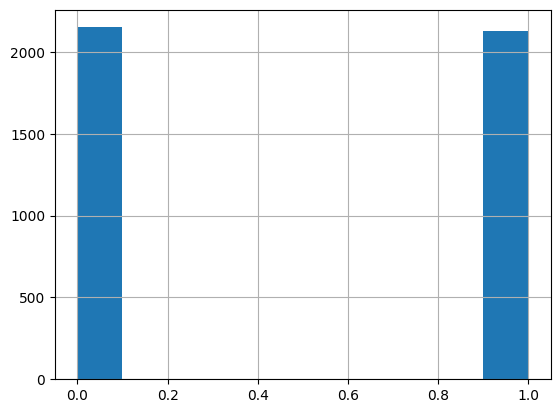

In [70]:
# sub_df.hist()
sub_df['Transported'].astype('int').hist()

In [71]:
sub_df.to_csv('sub2.csv', index = False)

In [72]:
!head sub2.csv

PassengerId,Transported
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
0027_01,True
0029_01,True
0032_01,True
0032_02,True


In [73]:
!kaggle competitions submit -f sub2.csv -m "Initial submission to Kaggle. Iter1" spaceship-titanic

100%|███████████████████████████████████████| 56.4k/56.4k [00:00<00:00, 166kB/s]
Successfully submitted to Spaceship Titanic

In [76]:
!kaggle competitions leaderboard spaceship-titanic --show | grep -E -n -e "Zach Zacharia" | tail -n 1

582:10891694  Zach Zacharia                                   2023-09-18 21:23:33  0.79985  


In [78]:
!kaggle competitions leaderboard spaceship-titanic --show

  teamId  teamName                                        submissionDate       score    
--------  ----------------------------------------------  -------------------  -------  
 8398674  CADang                                          2023-09-17 00:43:44  0.96118  
10309479  MLCV                                            2023-09-18 11:31:19  0.92518  
 8593894  Involutional Neural Network                     2023-09-06 15:23:29  0.90109  
10534604  Naresh K                                        2023-09-14 03:24:42  0.82183  
 8657182  random sampling                                 2023-08-22 06:53:33  0.82160  
10153553  Reia Li                                         2023-08-15 02:45:23  0.82137  
10245874  Çağatay Demirbaş                                2023-08-11 21:02:04  0.82066  
 9967377  Arun K Lenin                                    2023-09-18 06:14:53  0.81903  
10411033  Hüseyin Kalkan                                  2023-08-12 22:27:50  0.81809  
 9365828  clionnnnnn 